In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [1]:
import time

import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [26]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 256
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [27]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [28]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [29]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)

evo_batchsize = batchsize

strategy = CMA_ES(popsize=evo_batchsize, num_dims=env.num_actions, elite_ratio=0.6)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)

# Simulated Annealing

sim_anneal = SimAnneal(popsize=evo_batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

# Setting the Appropriate Strategy
strat = sim_anneal
params = sim_params

state = strat.initialize(rng, params)

start = time.time()
fitness_list = []

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = strat.ask(rng_gen, state, params)
    fitness = custom_rollout(x)
    state = strat.tell(x, fitness, state, params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")

CMA-ES - # Gen: 100|Fitness: 13.38131
Time: 13.794884204864502
CMA-ES - # Gen: 200|Fitness: -3.54595
Time: 20.091174125671387
CMA-ES - # Gen: 300|Fitness: -3.60638
Time: 25.908288955688477
CMA-ES - # Gen: 400|Fitness: -3.91274
Time: 31.877630949020386
CMA-ES - # Gen: 500|Fitness: -4.01046
Time: 38.08688831329346
CMA-ES - # Gen: 600|Fitness: -4.01046
Time: 42.96989107131958
CMA-ES - # Gen: 700|Fitness: -4.01046
Time: 47.85783505439758
CMA-ES - # Gen: 800|Fitness: -4.81471
Time: 52.67390203475952
CMA-ES - # Gen: 900|Fitness: -4.81471
Time: 57.48877310752869
CMA-ES - # Gen: 1000|Fitness: -4.81471
Time: 62.31961703300476
CMA-ES - # Gen: 1100|Fitness: -5.20239
Time: 67.09563326835632
CMA-ES - # Gen: 1200|Fitness: -5.29148
Time: 71.9308819770813
CMA-ES - # Gen: 1300|Fitness: -6.50130
Time: 77.44230699539185
CMA-ES - # Gen: 1400|Fitness: -7.73333
Time: 82.7927029132843
CMA-ES - # Gen: 1500|Fitness: -8.09184
Time: 88.03609919548035
CMA-ES - # Gen: 1600|Fitness: -8.57567
Time: 92.9258041381836


KeyboardInterrupt: 

[-0.52340707  0.77257936  0.31941443  1.01326493  1.14035453  0.93918792
  2.02742221  0.88471702  2.18937252  0.92853081  2.13787025  1.33727204
  1.83229459  2.01592285  1.58648283  2.20729751  1.60978678  1.93307266
  2.24455158  1.6472088   2.19761008  1.99642212  2.3255814   1.57697183
  2.02083528  1.09164008  1.66778552  1.45560154  1.79114328  1.65257254
  1.18881719  2.0388927   1.06165532  2.09903962  1.03015312  1.86435654
  0.98938964  1.51309094  0.84601215  1.13830123  0.16163132  1.13448534
 -0.25288607  1.12298559 -0.96173488  0.45170525 -0.9043678  -0.09615251
 -1.38873666 -0.81940732 -1.8078229  -1.44634982 -1.41172673 -2.09869843
 -1.13047638 -2.25898572 -1.62481454 -1.7301734  -1.51199795 -1.87029043
 -1.11840898 -2.07534599 -1.45184605 -2.01267762 -1.68149947 -1.36603746
 -1.38303348 -1.42607091 -0.80012874 -0.93933268 -0.12943117 -0.47154655
  0.6109188  -0.30396966  1.33573764  0.11166686  0.95495854  0.25475387
  0.34083284  0.36170608  0.18286261  0.58166303 -0

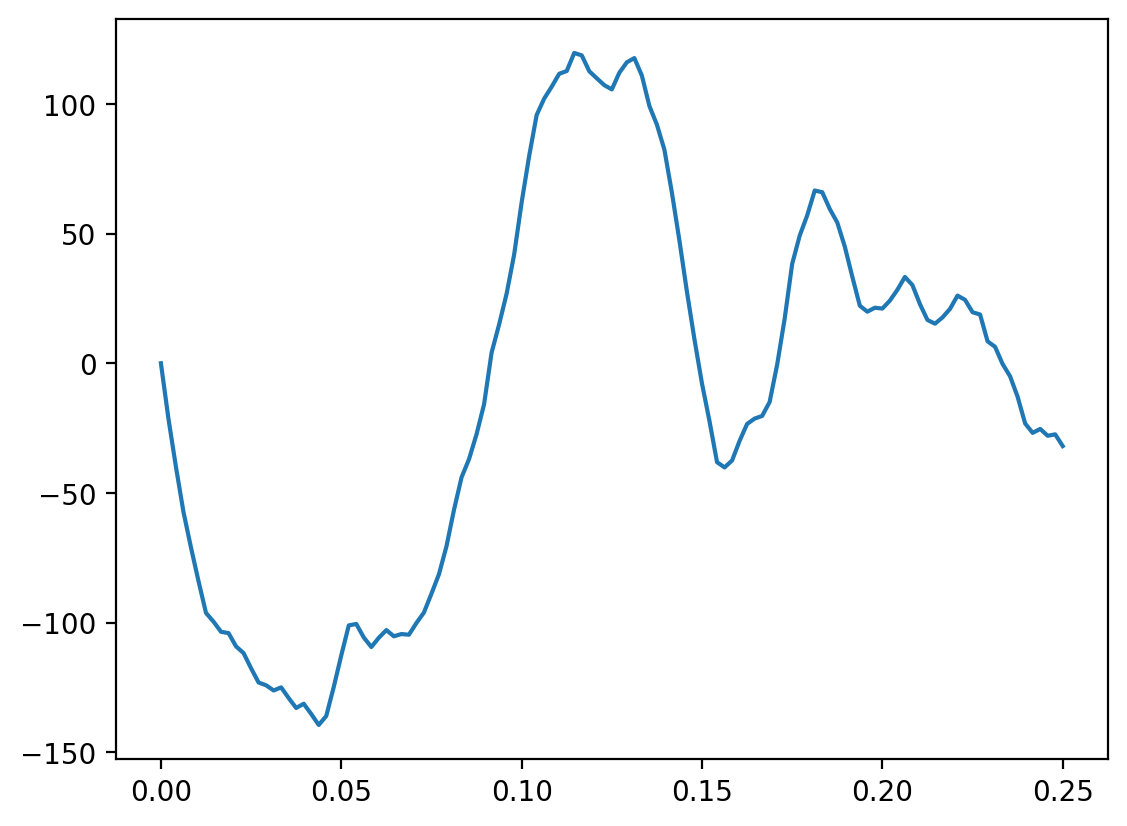

In [11]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [12]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
    _
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(pulse_end_times[0])
print(reward[0])
print(max_pf[0])

0.1125
0.20210505653529337
0.17222222222222222
22.406756050143617
2.447865414793042


0.1066515436359203
248
0.1066515436359203
248


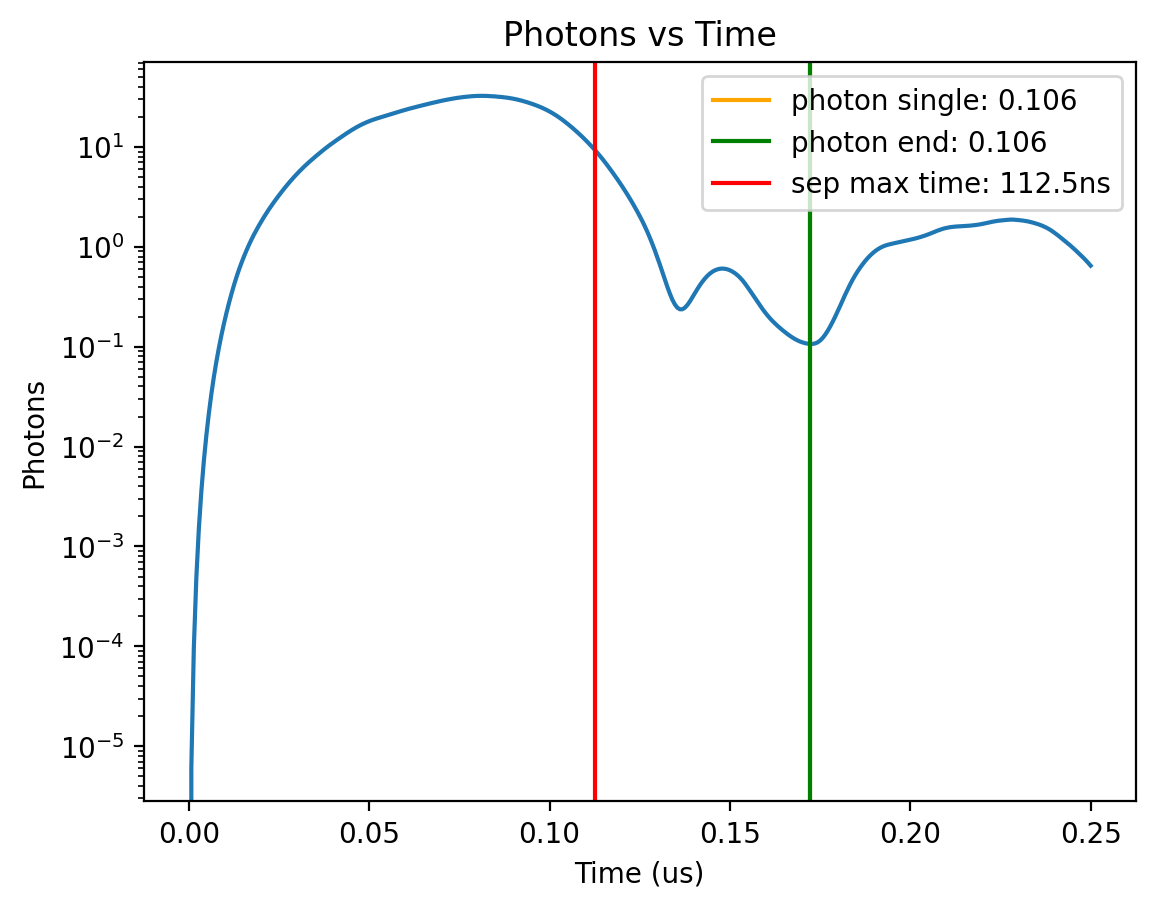

In [13]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)
single_sep = b_pf[0]

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = -1
ext_2 = -1

s_photon = jnp.abs(single_photon - nR)

argmin = jnp.argmin(s_photon[ext:ext_2]) + ext
min_photon = single_photon[argmin]

argmin_2 = jnp.argmin(s_photon[ext:ext_15]) + ext
min_photon_2 = single_photon[argmin_2]

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.yscale('log')
plt.legend()
plt.show()

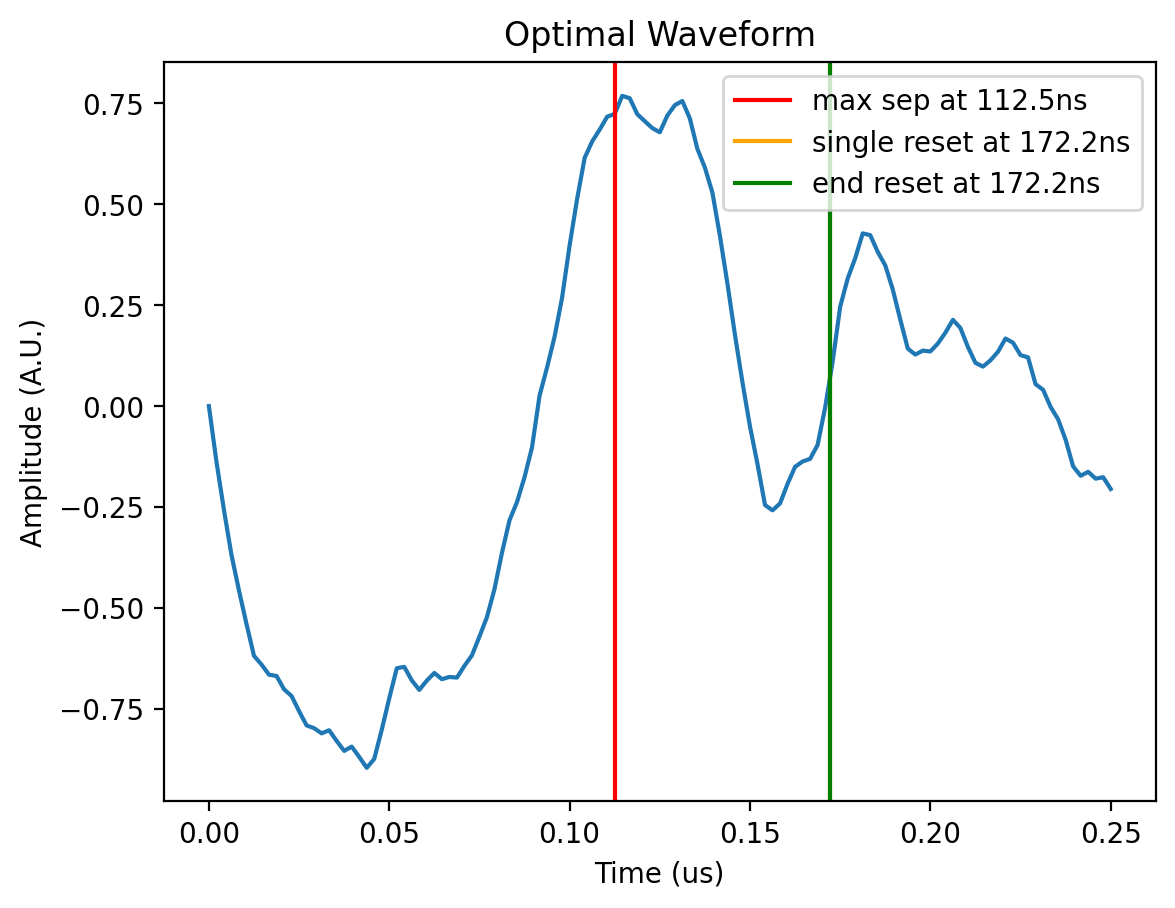

In [14]:
plt.plot(env.ts_action, action / env.mu / env.a0)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

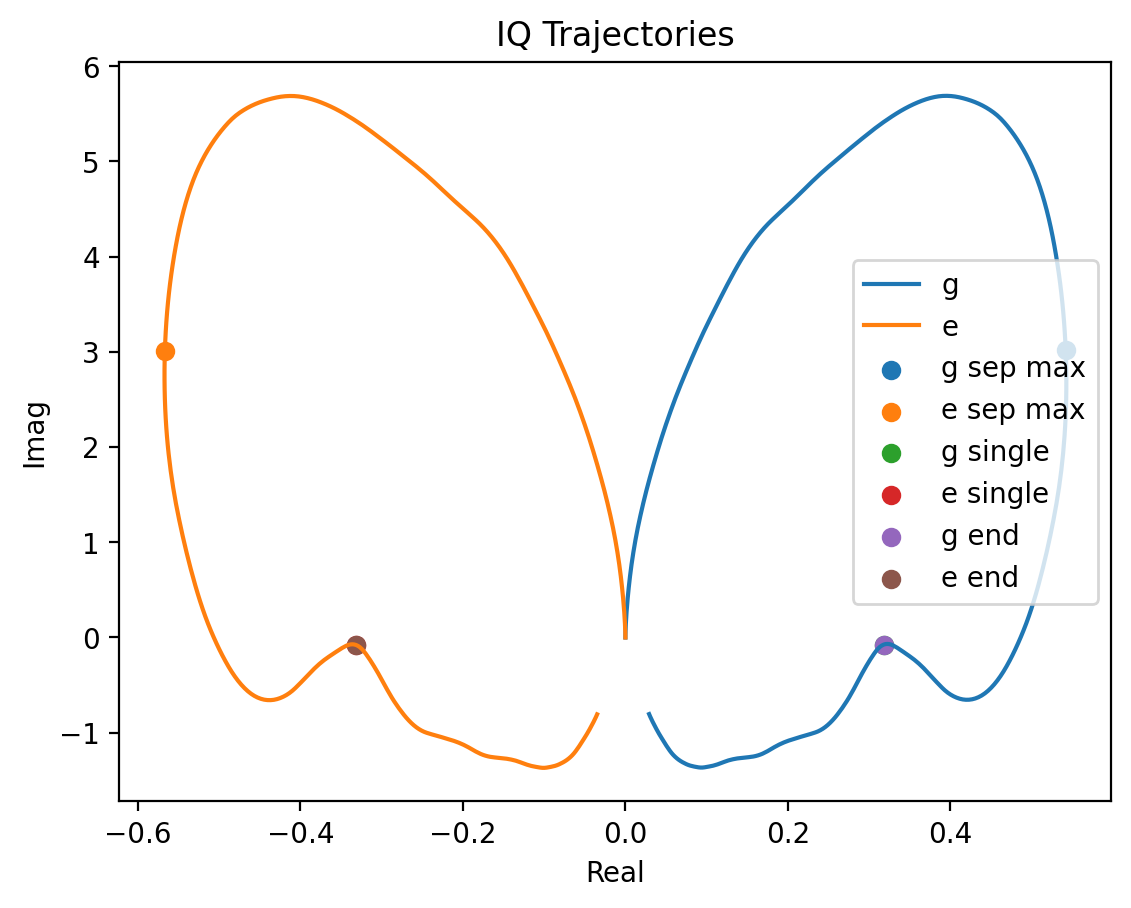

In [15]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


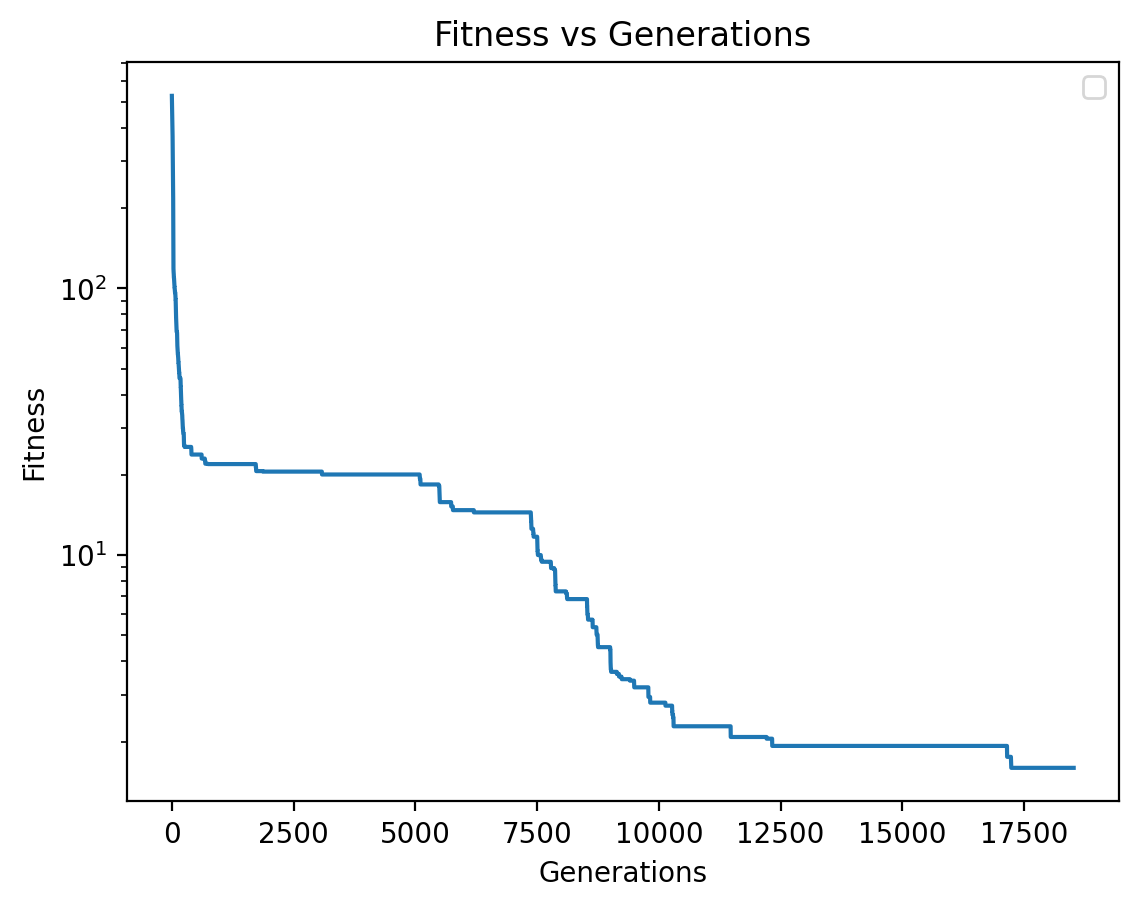

In [20]:
plt.plot(jnp.array(fitness_list) + 24)
plt.yscale('log')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness vs Generations')
plt.legend()